# Malaria Commodity Prediction
County predictions for malaria commodities.
This notebooks was created to study important properties we would discover in our time series model:
* It touches on Stationarity of data
* It touches on steps in data engineering for future recommendations
* It serves as a pre-test lab to see metrics of the model

### Note this is NOT the official notebook. Our official prototyping book is Model Lab.ipynb

Import the necessary libraries needed for our prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller


## Describe and view the data set we have
We want the date column and the demand prediction. So we use pandas <b>read_csv</b> argument of 'usecols=<['col1','col2',...,'coln']>
<br>
We alson drop null values using pandas dropna()

In [3]:
dataframe=pd.read_csv('../Data/data.csv',usecols=['periodid','Nakuru County']).dropna()
#retieve 4 rows
dataframe.head(4)

,periodid,Nakuru County
0,2022-01,998
1,2022-02,1159
2,2022-03,1268
3,2022-04,909


# Model Development

Feature engineering is done in the data frame from CSV where we 
* change the first column that is <b>'periodid'</b> to format 2022-01 instead of original 202201 given

In [4]:
#using the dates as the main predictors
dataframe['periodid']=pd.to_datetime(dataframe['periodid'])
dset_indexed=dataframe.set_index(['periodid'])

#print values from the first 4 top values
dset_indexed.head(4)


,Nakuru County
periodid,
2022-01-01,998
2022-02-01,1159
2022-03-01,1268
2022-04-01,909


In [5]:
#print last 4 values
dset_indexed.tail(4)

,Nakuru County
periodid,
2018-09-01,858
2018-10-01,454
2018-11-01,189
2018-12-01,791


# Nakuru County Time Series Model

Our main focus is placed on Nakuru where we must first see a plot of the demand in Nakuru.

### What is the trend of commodity demand of malarial drugs in Nakuru? 
And the trend we tend to discuss with a graph spans across 5 years

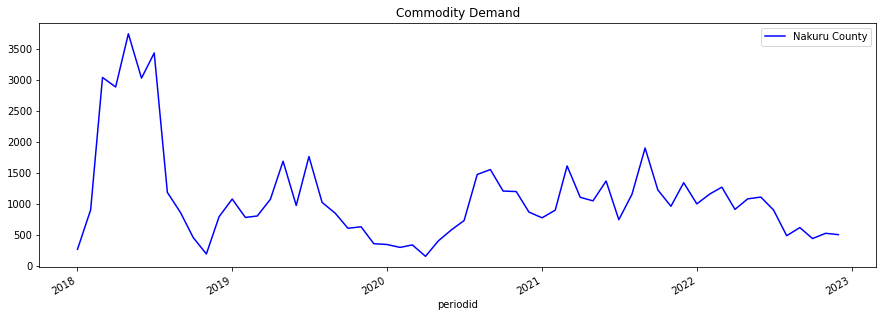

In [7]:

dset_indexed.plot(style='-', figsize=(15,5),color='blue',title='Commodity Demand')
plt.show()

### Checking the stationality of the data

In [8]:
roll_mean=dset_indexed.rolling(window=12).mean() #12 months
roll_std=dset_indexed.rolling(window=12).std()

print(f'Rolling Mean: {roll_mean}, Rolling Standard Deviation: {roll_std}')

Rolling Mean:             Nakuru County
periodid                 
2022-01-01            NaN
2022-02-01            NaN
2022-03-01            NaN
2022-04-01            NaN
2022-05-01            NaN
2022-06-01            NaN
2022-07-01            NaN
2022-08-01            NaN
2022-09-01            NaN
2022-10-01            NaN
2022-11-01            NaN
2022-12-01     831.750000
2021-01-01     813.000000
2021-02-01     791.166667
2021-03-01     819.750000
2021-04-01     836.000000
2021-05-01     833.333333
2021-06-01     854.916667
2021-07-01     841.833333
2021-08-01     897.500000
2021-09-01    1004.583333
2021-10-01    1070.083333
2021-11-01    1106.416667
2021-12-01    1176.333333
2020-01-01    1140.416667
2020-02-01    1090.250000
2020-03-01     983.916667
2020-04-01     904.500000
2020-05-01     850.500000
2020-06-01     784.750000
2020-07-01     783.666667
2020-08-01     810.416667
2020-09-01     781.416667
2020-10-01     779.833333
2020-11-01     799.666667
2020-12-01     760.08333

We then wanna do a visualization for our rolling

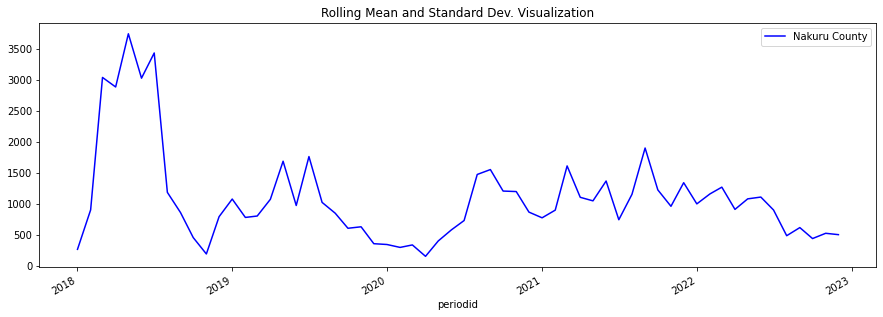

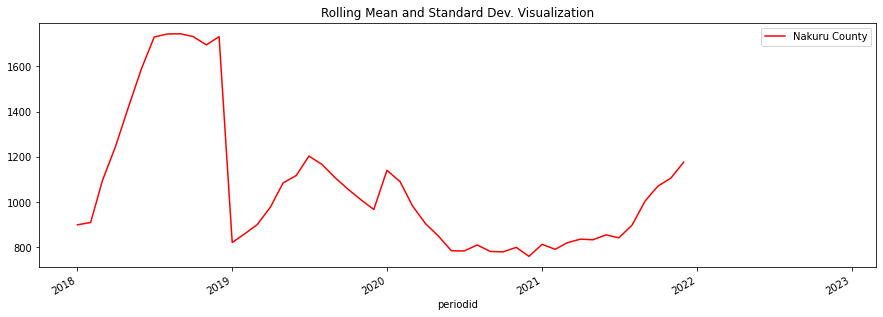

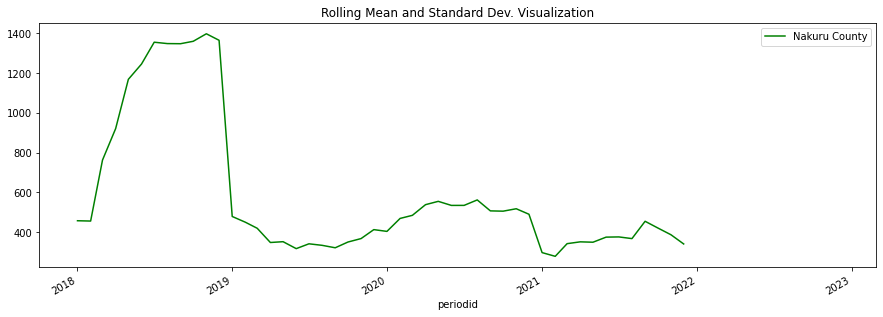

In [17]:
original_data=dset_indexed.plot(style='-', figsize=(15,5),color='blue',title='Rolling Mean and Standard Dev. Visualization')
mean=roll_mean.plot(style='-', figsize=(15,5),color='red',title='Rolling Mean and Standard Dev. Visualization',legend='Rolling Mean')
std_dev=roll_std.plot(style='-', figsize=(15,5),color='green',title='Rolling Mean and Standard Dev. Visualization',legend='Rolling Standard Deviation')

plt.show()

As show in the plot figure above the data we have is not stationery according to the plots shown above

One last test using <i><b>Dickey Fuller Test</b></i>

In [89]:


print(f'Results of out Dickey-Fuller Test:')
test=adfuller(dset_indexed['Nakuru County'], autolag='AIC')
output=pd.Series(test[0:4], index=['Test Statistics','p-value','Lags Used','Observations Used'])

for k,v in test[4].items():
    output['Critical Value (%s)'%k]=v

#print output
output

Results of out Dickey-Fuller Test:


Test Statistics         -2.238088
p-value                  0.192713
Lags Used                5.000000
Observations Used       54.000000
Critical Value (1%)     -3.557709
Critical Value (5%)     -2.916770
Critical Value (10%)    -2.596222
dtype: float64

Important conclusions
* Our p-value is small hence desired
* Critical value is less than test stats hence we cannot reject null hypotheses- data is not stationary

To know its state of being stationary we estimate the trend

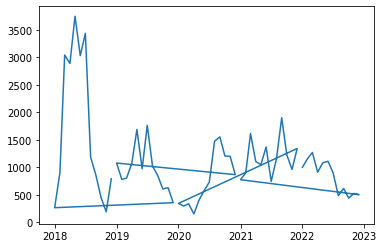

In [90]:

dset_indexed_logScaled=np.log(dset_indexed)
plt.plot(dset_indexed)

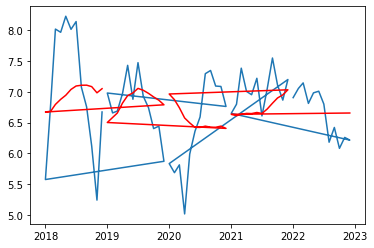

In [91]:
moving_mean=dset_indexed_logScaled.rolling(window=12).mean() #12 months
moving_std=dset_indexed_logScaled.rolling(window=12).std()
plt.plot(dset_indexed_logScaled)
plt.plot(moving_mean,color='red')

Hence not stationary, it is moving

Trying to make it stationary using Subtraction

In [92]:
datasetLogScale=(dset_indexed_logScaled-moving_mean).dropna()
datasetLogScale.head(15)

,Nakuru County
periodid,
2022-12-01,-0.439736
2021-01-01,0.015226
2021-02-01,0.185358
2021-03-01,0.750961
2021-04-01,0.356850
2021-05-01,0.306348
2021-06-01,0.555533
2021-07-01,-0.039498
2021-08-01,0.328144


### Create function to automatically test if data is stationary

In [93]:
def stationary_test(timeseries):
    moving_mean=timeseries.rolling(window=12).mean() #12 months
    moving_std=timeseries.rolling(window=12).std()
    original_data=plt.plot(timeseries,color='red',label='Original Data')
    mean=plt.plot(moving_mean,color='blue',label='Rolling Mean')
    std_dev=plt.plot(moving_std,color='orange',label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Dev. Visualization')
    plt.show(block=False)
    
    

    print(f'Results of out Dickey-Fuller Test:')
    test=adfuller(timeseries['Nakuru County'], autolag='AIC')
    output=pd.Series(test[0:4], index=['Test Statistics','p-value','Lags Used','Observations Used'])

    for k,v in test[4].items():
        output['Critical Value (%s)'%k]=v

    #print output
    print(output)

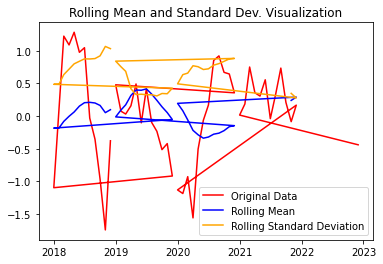

Results of out Dickey-Fuller Test:
Test Statistics         -4.920640
p-value                  0.000032
Lags Used                3.000000
Observations Used       45.000000
Critical Value (1%)     -3.584829
Critical Value (5%)     -2.928299
Critical Value (10%)    -2.602344
dtype: float64


In [94]:
stationary_test(datasetLogScale)

Hence now we have our desired result
Important conclusions
* Our p-value is small hence desired
* Critical value is high than test stats hence we can reject null hypotheses- data is not stationary

Trend estimation is now promising

### Shaping data values to Time Series for forcasting

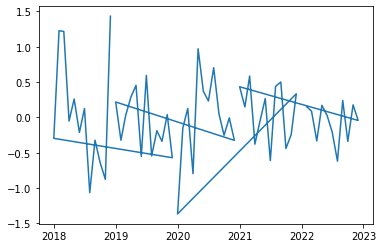

In [95]:
#we shift our previous values that were minused
#we are shifting by 1 or lag of 1- how many times we have differentiated the series
dsetlogDiffShifting=dset_indexed_logScaled-dset_indexed_logScaled.shift()
plt.plot(dsetlogDiffShifting)

Plotting the shift

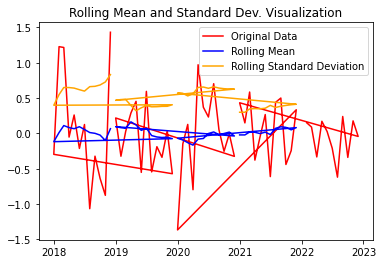

Results of out Dickey-Fuller Test:
Test Statistics         -5.288333
p-value                  0.000006
Lags Used                6.000000
Observations Used       52.000000
Critical Value (1%)     -3.562879
Critical Value (5%)     -2.918973
Critical Value (10%)    -2.597393
dtype: float64


In [96]:
dsetlogDiffShifting.dropna(inplace=True)
stationary_test(dsetlogDiffShifting)

## Main sections for our time series

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose
dataframe.reset_index(inplace=True)
dataframe['periodid'] = pd.to_datetime(dataframe['periodid'])
dataframe = dataframe.set_index('periodid')

decomposition=seasonal_decompose(dataframe)

#trend in the county
trend=decomposition.trend
#seasons
seasonal=decomposition.seasonal
#residual
residual=decomposition.resid

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [71]:


plt.subplot(411)
plt.plot(dset_indexed_logScaled,label='Original')
plt.legend(loc='best')
plt.subplot(412)

plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)

plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)

plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData=residual
decomposedLogData.dropna(inplace=True)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

Plot Decomposed data log

In [47]:
stationary_test(decomposedLogData)

NameError: name 'decomposedLogData' is not defined

In [ ]:
#baringo county
y_tharaka=np.array(dataframe['Nakuru County'],dtype='float32')
print(y_tharaka)
#histogram

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_tharaka,test_size=0.3,random_state=None)


In [ ]:
X_test

In [ ]:
print(f"X_train shape: {X_train.shape[0]}")
print(f"X_test shape: {X_test.shape[0]}")
print(f"y_train shape: {y_train.shape[0]} and data type: {y_train.dtype}")
print(f"y_test shape: {y_test.shape[0]}")

# Looking at Time Series

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

t_series=TimeSeriesSplit()
print(t_series)

for i,(train_index,test_index) in enumerate(t_series.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
commodity_demand = dataframe.groupby(["periodname"])["Nakuru County"].mean()
commodity_demand.plot(ax=ax)
_ = ax.set(
    title="",
    xticks=[i*5for i in range(12)],
    xticklabels=["Jan", "Feb", "March", "April", "May", "June", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"],
    xlabel="Season",
    ylabel="Malarial Drug Demand",
)

In [ ]:
X = dataframe['perioddescription'].value_counts()
X

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
ts_crossval = TimeSeriesSplit(
    n_splits=4,
    gap=4,
    max_train_size=48,
    test_size=12,
)

In [ ]:
all_splits = list(ts_crossval.split(dataframe['periodid'], dataframe['Nakuru County']))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]

In [ ]:
dataframe['periodid'].iloc[test_0]

In [ ]:
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

label_encoder=preprocessing.LabelEncoder()


In [ ]:
dataframe['perioddescription']=label_encoder.fit_transform(dataframe['perioddescription'])
dataframe['perioddescription'].unique

In [ ]:
#use test set to give prediction
X_b=dataframe['periodid']
y_b=dataframe['Nakuru County']

gbr_model=LinearRegression()
#fit training data
gbr_model.fit(X_b.iloc[train_0].values.reshape(-1,1),y_b.iloc[train_0])

In [ ]:

y_hat=gbr_model.predict(X_b.iloc[test_0].values.reshape(-1,1))
y_hatmean=y_hat.mean()
y_hatmean

In [ ]:
#fit training data
gbr_model.fit(X_b.iloc[train_1].values.reshape(-1,1),y_b.iloc[train_1])

y_hat_=gbr_model.predict(X_b.iloc[test_1].values.reshape(-1,1))
y_hat_mean=y_hat_.mean()
y_hat_mean

In [ ]:
#fit training data
gbr_model.fit(X_b.iloc[train_2].values.reshape(-1,1),y_b.iloc[train_2])

y_hat_2=gbr_model.predict(X_b.iloc[test_2].values.reshape(-1,1))
y_hat_2_mean=y_hat_2.mean()
y_hat_2_mean

In [ ]:
#fit training data
gbr_model.fit(X_b.iloc[train_3].values.reshape(-1,1),y_b.iloc[train_3])

y_hat_3=gbr_model.predict(X_b.iloc[test_3].values.reshape(-1,1))
y_hat_3_mean=y_hat_3.mean()
y_hat_3_mean
y_hat_3

In [ ]:
last_hours = slice(-10, None)
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Predictions by linear models")
ax.plot(
    y_b.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    y_hat[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
_ = ax.legend()